In [1]:
%load_ext autoreload
%autoreload 2

# Calphad UQ calculations using `qt-tdbx`

This example shows basic usage of the `qt-tdbx` package developed by QuesTek Innovations LLC.

## Prepare Thermo-Calc scripts
It is user's responsibility to provide a script for desired Calphad calculations. In general, this script starts with a TC System object from the `get_new_system()` function, and return values of desired properties.

In [2]:
from tc_python import CalculationAxis
from qt_tdbx.tc_helpers import get_new_system

def get_phase_diagram(parameters):
    new_system = get_new_system(parameters)
    x_values, y_values = [], []    
    results = (
        new_system
        .with_phase_diagram_calculation()
        .with_first_axis(CalculationAxis('X(Cr)').set_min(0).set_max(1))
        .with_second_axis(CalculationAxis('T').set_min(1000).set_max(2500))
        .calculate()
        .get_values_grouped_by_stable_phases_of('X(Cr)', 'T')
    )
    for group in results.get_lines().values():
        x_values.append(group.x)
        y_values.append(group.y)
    return x_values, y_values


def get_enthalpy_solid(parameters):
    new_system = get_new_system(parameters)
    x_values, y_values = [], []
    results = (new_system
              .with_property_diagram_calculation()
              .with_axis(CalculationAxis('X(Cr)').set_min(0).set_max(1))
              .set_condition('T', 1538)
              .with_reference_state('Ni', 'FCC_A1')
              .with_reference_state('Cr', 'BCC_A2')
              .calculate()
              .get_values_grouped_by_quantity_of('X(Cr)', 'HMR'))
    for group in results.values():
        x_values.append(group.x)
        y_values.append(group.y)
    return x_values, y_values


def get_solidification_range(parameters):
    new_system = get_new_system(parameters)
    results = (new_system
               .with_property_model_calculation('Liquidus and solidus temperature')
               .set_composition('Cr', 70)
               .calculate())
    solidus = results.get_value_of('Solidus temperature')
    liquidus = results.get_value_of('Liquidus temperature')
    diff = liquidus - solidus
    return diff

## Initialize Tdbp and get UQ parameters
First, user needs to provide the path to the `.tdbx` file and elements of interest. As a rule of thumb, this size value must be high enough to capture the distributions of UQ parameters.

In [3]:
from qt_tdbx import Tdbx

tdbx = Tdbx('NiCr.tdbx', ['Ni', 'Cr'])
# Check the parameter space size:
display(len(tdbx.parameters))
# Read an example of one parameter set
display(tdbx.parameters[0])

900

{'L(BCC_A2,Cr,Ni;0)': '15900.1859432963 - 10.1261930510479*T',
 'L(BCC_A2,Cr,Ni;1)': '25175.9486345382 - 5.97937476073203*T',
 'L(FCC_A1,Cr,Ni;0)': '6678.0552921134 - 10.7619640852937*T',
 'L(FCC_A1,Cr,Ni;1)': '30220.5579370166 - 15.9031001000751*T',
 'L(LIQUID,Cr,Ni;0)': '3.27326997300504*T - 15131.5776732382',
 'L(LIQUID,Cr,Ni;1)': '2.39275178119467*T + 836.325871536516'}

## Run the high-throughput calculation
During this step, 900 calculations will be performed to capture the uncertainties in a phase diagram. The under-the-hood steps include:

1. Using the original TDB file, generate a TC System object.
1. Run a loop of 900 calculations using a pool of `n_procs` processors. Within each calculation, copy the initial TC System as the starting point. Then update the GES parameters extracted from TDBX.
1. Collect results from the 900 calculations.

**This step may take minutes or hours to finish, depending on your pool size.**

In [4]:
from multiprocessing import Pool
from qt_tdbx.tc_helpers import initializer, clean_up

n_procs = 10
pool = Pool(n_procs, initializer=initializer)

try:
    phase_diagram = pool.map(get_phase_diagram, tdbx.parameters)
    enthalpy = pool.map(get_enthalpy_solid, tdbx.parameters)
    solidification = pool.map(get_solidification_range, tdbx.parameters)
except Exception as e:
    print(e)
finally:
    clean_up(pool, n_procs)

TC-Python #3 is closed.
TC-Python #7 is closed.
TC-Python #8 is closed.
TC-Python #0 is closed.
TC-Python #4 is closed.
TC-Python #9 is closed.
TC-Python #5 is closed.
TC-Python #1 is closed.
TC-Python #2 is closed.
TC-Python #6 is closed.


## Visualization
This final step visualizes desired properties with uncertainties.

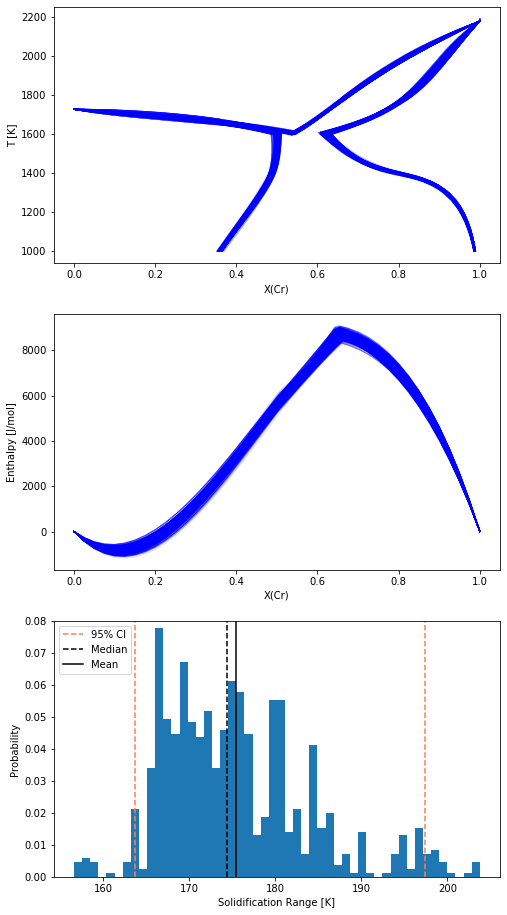

In [5]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 16))

for x_values, y_values in phase_diagram:
    for x, y in zip(x_values, y_values):
        ax1.plot(x, y, alpha=.1, color='blue', linewidth=1)
ax1.set_xlabel('X(Cr)')
ax1.set_ylabel('T [K]')

for x_values, y_values in enthalpy:
    for x, y in zip(x_values, y_values):
        ax2.plot(x, y, alpha=.1, color='blue', linewidth=1)
ax2.set_xlabel('X(Cr)')
ax2.set_ylabel('Enthalpy [J/mol]')

perc = np.percentile(solidification, [2.5, 50, 97.5])
ylim = [0, 0.08]
ax3.hist(solidification, density=True, bins=50)
ax3.set_ylim(ylim)
ax3.plot([perc[0]] * 2, ylim, '--', c='coral', label='95% CI')
ax3.plot([perc[2]] * 2, ylim, '--', c='coral')
ax3.plot([perc[1]] * 2, ylim, '--', c='black', label='Median')
ax3.plot([np.mean(solidification)] * 2, ylim, c='black', label='Mean')
ax3.set_xlabel('Solidification Range [K]')
ax3.set_ylabel('Probability')
ax3.legend();